In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv("exp_results/exp_siamese_m2_100/results.csv", index_col=0)

In [3]:
df

,train_con_loss,train_sim_acc,val_con_loss,val_sim_acc,test_con_loss,test_sim_acc,lr
epoch,,,,,,,
1,39.516620,0.598959,33.983407,0.643345,33.902289,0.644198,0.000497
2,31.047545,0.664391,30.757760,0.642768,30.605632,0.639889,0.000488
3,28.263228,0.690060,28.793825,0.653051,29.083485,0.648315,0.000473
4,26.493895,0.706584,28.009504,0.688131,28.481606,0.678476,0.000452
5,25.118598,0.719979,27.555217,0.673234,27.643628,0.678763,0.000427
6,23.810235,0.732823,27.170903,0.707352,27.373562,0.704424,0.000397
7,22.374965,0.747488,26.835572,0.735896,27.040841,0.729223,0.000364
8,21.317210,0.759798,26.893776,0.719558,27.230048,0.714477,0.000327
9,19.768249,0.777150,26.628367,0.725805,26.682449,0.726254,0.000289


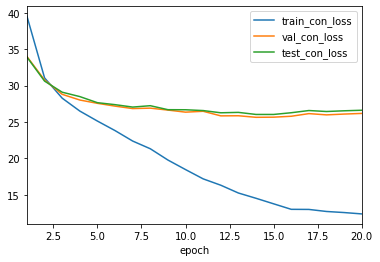

In [4]:
df[["train_con_loss", "val_con_loss", "test_con_loss"]].plot()

In [33]:
import torch
from network.resnet import ResidualEmbNetwork


emb_net = ResidualEmbNetwork()
emb_net.load_state_dict(torch.load("exp_results/exp_siamese_m2_1/_emb_net_20.pth"))

<All keys matched successfully>

In [6]:
from utils.datasets import DeepFashionDataset
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from config.deep_fashion import DeepFashionConfig as cfg
from torch.utils.data import DataLoader
trans = Compose([
    Resize(cfg.sizes), ToTensor(),
    Normalize(cfg.mean, cfg.std)
])
train_ds = DeepFashionDataset(
    cfg.root_dir, 'train', transform=trans)
val_ds = DeepFashionDataset(
    cfg.root_dir, 'val', transform=trans)
test_ds = DeepFashionDataset(
    cfg.root_dir, 'test', transform=trans)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [19]:
%load_ext autoreload
%autoreload 2
from utils import extract_embeddings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
val_embs, _ = extract_embeddings(emb_net, DataLoader(val_ds, batch_size=128, num_workers=os.cpu_count()))

Extract emb vecs: 100%|██████████| 82/82 [00:16<00:00,  5.06it/s]


In [35]:
test_embs, _ = extract_embeddings(emb_net, DataLoader(test_ds, batch_size=128, num_workers=os.cpu_count()))

Extract emb vecs: 100%|██████████| 82/82 [00:16<00:00,  5.06it/s]


In [22]:
from tqdm import tqdm
from annoy import AnnoyIndex

In [36]:
t = AnnoyIndex(val_embs.shape[1], metric='euclidean')

In [37]:
for i, emb_vec in enumerate(val_embs):
    t.add_item(i, emb_vec.cpu().numpy())

In [38]:
t.build(100)

True

Text(0.5, 1.0, 'Blazer')

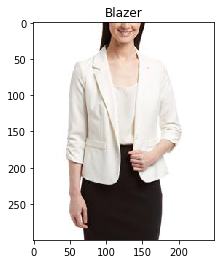

In [44]:
search_idx = 500
img, cat = test_ds.get_img_cat(search_idx)
plt.imshow(img)
plt.title(cat)

In [45]:
idx = t.get_nns_by_vector(test_embs[search_idx].cpu().numpy(), 5)

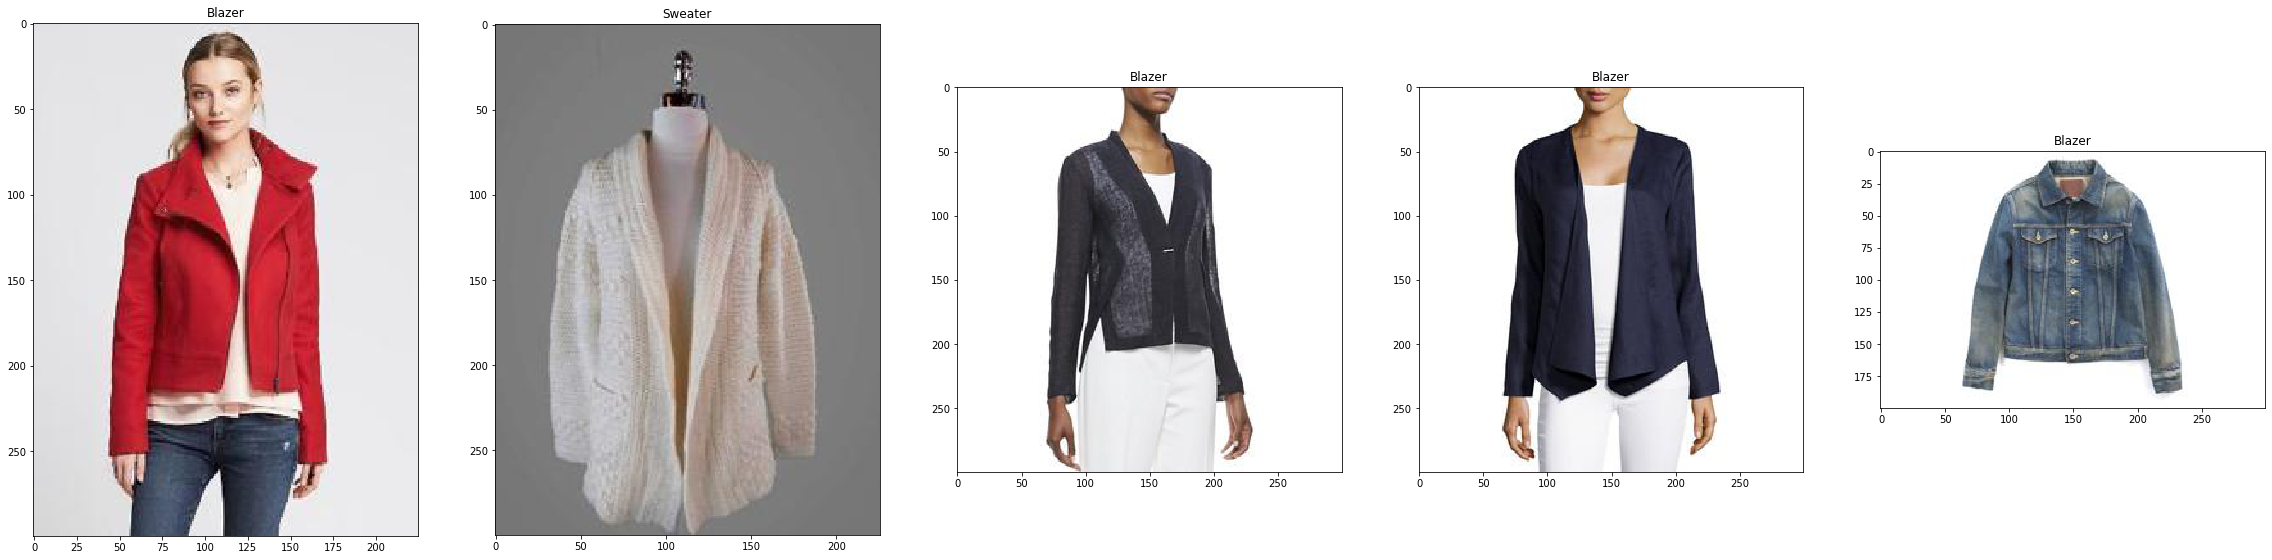

In [46]:
fig, axs = plt.subplots(ncols=len(idx), figsize=(40, 40))
for j, i in enumerate(idx):
    img, cat = val_ds.get_img_cat(i)
    axs[j].imshow(img)
    axs[j].set_title(cat)

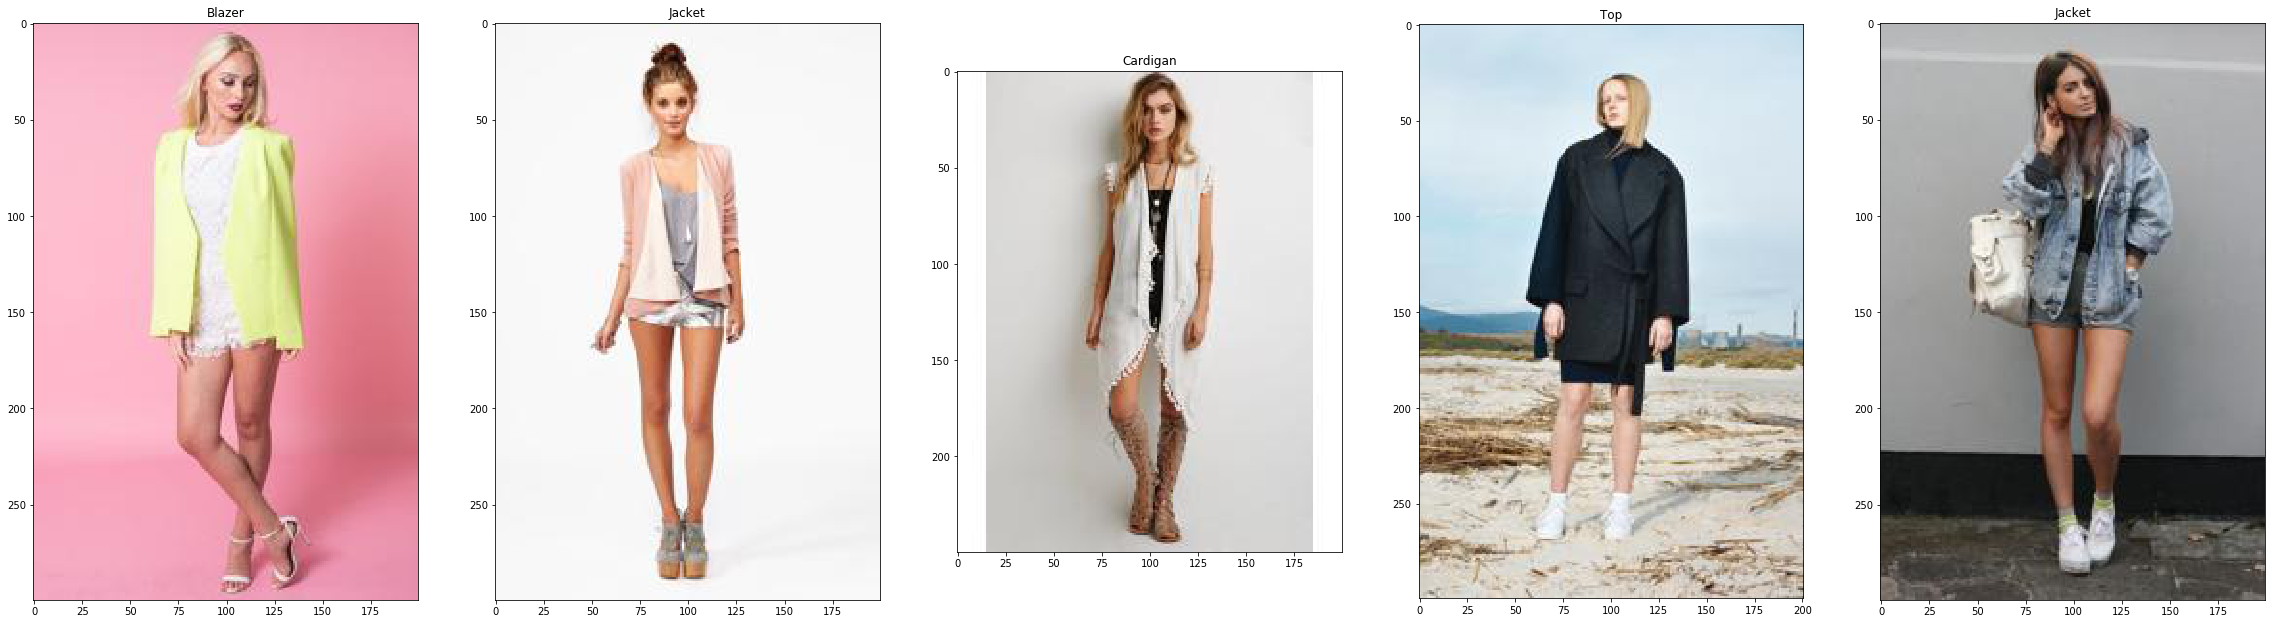

In [32]:
fig, axs = plt.subplots(ncols=len(idx), figsize=(40, 40))
for j, i in enumerate(idx):
    img, cat = val_ds.get_img_cat(i)
    axs[j].imshow(img)
    axs[j].set_title(cat)